In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [2]:
import fastai
from fastai import data
from fastai.collab import *
from fastai.tabular.all import *
path = fastai.data.external.untar_data(data.external.URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [5]:
top_users = ratings['user'].value_counts()[:15]
top_movies = ratings['movie'].value_counts()[:15]
ratings[
    ratings['user'].isin(top_users) &
    ratings['movie'].isin(top_movies)] \
.drop(['timestamp'], axis=1) \
.pivot(index='user', columns='movie', values='rating') \
.fillna(' ')

movie,392,394,413,420,429,431,452,485,508,509,583
user,,,,,,,,,,,
405,5.0,,,5.0,5.0,3.0,5.0,,,1.0,1.0
435,3.0,4.0,2.0,4.0,,3.0,,,,,
480,,,,,,,,4.0,,,
484,4.0,,,,,4.0,,,,,
493,,,,,,5.0,,,,,
518,,,,,,,,,3.0,,
540,,,,,,,,,4.0,,


In [6]:
dls = CollabDataLoaders.from_df(
    ratings, user_name='user', item_name='title', rating_name='rating',
    bs=64)
dls.show_batch()

,user,title,rating
0,497,Jaws 2 (1978),2
1,650,"Fugitive, The (1993)",3
2,363,Butch Cassidy and the Sundance Kid (1969),3
3,280,Boys on the Side (1995),5
4,405,Kalifornia (1993),3
5,716,Grosse Pointe Blank (1997),4
6,70,Bram Stoker's Dracula (1992),4
7,144,"Fish Called Wanda, A (1988)",5
8,823,Liar Liar (1997),3
9,486,Soul Food (1997),5


In [7]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 3
user_embeds = torch.randn(n_users, n_factors)
movie_embeds = torch.randn(n_movies, n_factors)
user_embeds, movie_embeds

(tensor([[ 1.0708,  0.3129, -0.2578],
         [ 1.2332,  0.2817,  0.3580],
         [ 0.1191,  1.0742, -0.9416],
         ...,
         [ 0.3034,  0.1520, -0.2333],
         [ 0.2908,  1.1777,  0.6299],
         [-0.0899, -0.2675, -0.0415]]),
 tensor([[-0.6418, -0.9771, -1.5060],
         [ 1.6658,  0.2626,  0.3424],
         [-1.1352, -1.0037,  0.9585],
         ...,
         [ 0.1589, -0.1022, -0.2485],
         [-0.2740,  0.6028, -0.6335],
         [ 0.9795, -1.0041,  0.8959]]))

In [8]:
one_hot(2, n_users).float().t() @ user_embeds, \
    one_hot(0, n_movies).float().t() @ movie_embeds


(tensor([ 0.1191,  1.0742, -0.9416]), tensor([-0.6418, -0.9771, -1.5060]))

In [9]:
import fastai.torch_core

class Collab(fastai.torch_core.Module):
    def __init__(self, n_rows, n_cols, dims):
        self.rows = fastai.layers.Embedding(n_rows, dims)
        self.cols = fastai.layers.Embedding(n_cols, dims)

    def forward(self, input):
        # look up this batch of rows
        rows = self.rows(input[:,0])
        # look up this batch of cols
        cols = self.cols(input[:,1])
        # dot product rows and cols, then sum horizontally
        return (rows * cols).sum(dim=1)

model = Collab(n_users, n_movies, n_factors)

# user2's embedding twice
print(model.rows(torch.tensor([2, 2])))
# movie0 and movie1's embeddings
print(model.cols(torch.tensor([0, 1])))
# dot product user0 . movie0 and user0 x movie1
print(model.rows(torch.tensor([2, 2])) *
      model.cols(torch.tensor([0, 1])))
# sum horizontally
print((model.rows(torch.tensor([2, 2])) *
      model.cols(torch.tensor([0, 1]))).sum(axis=1))

model(torch.tensor([[2, 0], [2, 1]]))

tensor([[0.0089, 0.0142, 0.0164],
        [0.0089, 0.0142, 0.0164]], grad_fn=<EmbeddingBackward0>)
tensor([[ 0.0014, -0.0101, -0.0079],
        [ 0.0122, -0.0059,  0.0016]], grad_fn=<EmbeddingBackward0>)
tensor([[ 1.2166e-05, -1.4252e-04, -1.2991e-04],
        [ 1.0788e-04, -8.3360e-05,  2.5976e-05]], grad_fn=<MulBackward0>)
tensor([-2.6026e-04,  5.0499e-05], grad_fn=<SumBackward1>)


tensor([-2.6026e-04,  5.0499e-05], grad_fn=<SumBackward1>)

In [10]:
learn = fastai.learner.Learner(
    dls, model,
    loss_func=fastai.losses.MSELossFlat())

In [11]:
learn.fit_one_cycle(n_epoch=5, lr_max=5e-3)

epoch,train_loss,valid_loss,time
0,6.422824,5.620477,00:09
1,1.219276,1.298613,00:09
2,0.964184,1.074299,00:09
3,0.938699,1.020390,00:10
4,0.919777,1.012296,00:10


In [12]:
class CollabRanged(fastai.torch_core.Module):
    def __init__(self, n_rows, n_cols, dims, out_range=(.5, 5.5)):
        self.rows = fastai.layers.Embedding(n_rows, dims)
        self.cols = fastai.layers.Embedding(n_cols, dims)
        self.out_range = out_range

    def forward(self, input):
        # look up this batch of rows
        rows = self.rows(input[:,0])
        # look up this batch of cols
        cols = self.cols(input[:,1])
        # dot product rows and cols, then sum horizontally
        return fastai.layers.sigmoid_range(
            (rows * cols).sum(dim=1),
            *self.out_range)

model = CollabRanged(n_users, n_movies, n_factors)
learn = fastai.learner.Learner(
    dls, model,
    loss_func=fastai.losses.MSELossFlat())
learn.fit_one_cycle(n_epoch=5, lr_max=5e-3)

epoch,train_loss,valid_loss,time
0,1.092058,1.097981,00:11
1,0.939933,0.991199,00:11
2,0.898554,0.967208,00:10
3,0.895497,0.952137,00:09
4,0.890780,0.949326,00:10


In [13]:
class CollabBiasedRanged(fastai.torch_core.Module):
    def __init__(self, n_rows, n_cols, dims, out_range=(.5, 5.5)):
        self.rows = fastai.layers.Embedding(n_rows, dims)
        self.row_bias = fastai.layers.Embedding(n_rows, 1)
        self.cols = fastai.layers.Embedding(n_cols, dims)
        self.col_bias = fastai.layers.Embedding(n_cols, 1)
        self.out_range = out_range

    def forward(self, input):
        # look up this batch of rows
        rows = self.rows(input[:,0])
        row_bias = self.row_bias(input[:,0])
        # look up this batch of cols
        cols = self.cols(input[:,1])
        col_bias = self.col_bias(input[:,1])
        # dot product rows and cols, then sum horizontally
        res = (rows * cols)
        res = res.sum(dim=1)
        res.add_(row_bias.reshape(-1))
        res.add_(col_bias.reshape(-1))
        return fastai.layers.sigmoid_range(res, *self.out_range)

model = CollabBiasedRanged(n_users, n_movies, n_factors)
learn = fastai.learner.Learner(
    dls, model,
    loss_func=fastai.losses.MSELossFlat())
learn.fit_one_cycle(n_epoch=5, lr_max=5e-3)

epoch,train_loss,valid_loss,time


In [14]:
model = CollabBiasedRanged(n_users, n_movies, n_factors)
learn = fastai.learner.Learner(
    dls, model,
    loss_func=fastai.losses.MSELossFlat())
# Need to try different wd
learn.fit_one_cycle(n_epoch=5, lr_max=5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.966363,0.969975,00:11
1,0.844017,0.902139,00:10
2,0.838030,0.880825,00:11
3,0.808672,0.866480,00:11
4,0.796426,0.863779,00:10


# Interpreting

In [15]:
# top_movies
[
    dls.classes['title'][i]
    for i in learn.model.col_bias.weight.squeeze().argsort(descending=True)[:5]
]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Good Will Hunting (1997)',
 'Casablanca (1942)',
 'Shawshank Redemption, The (1994)']

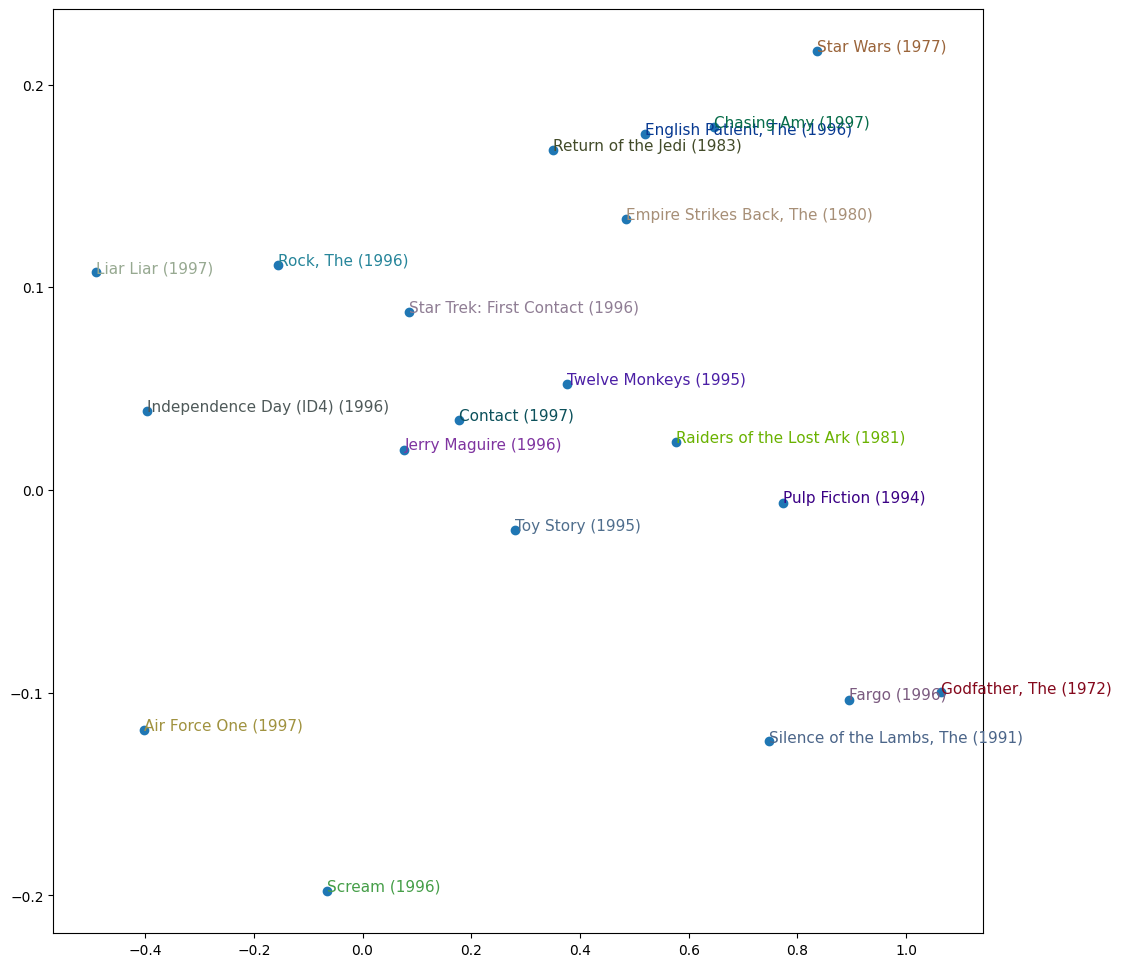

In [16]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.cols.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(20))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Using fastai.collab

In [17]:
learn = collab_learner(dls, n_factors=50, y_range=(0.5, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.898935,0.950377,00:10
1,0.642779,0.896534,00:10
2,0.537916,0.873985,00:10
3,0.461524,0.863944,00:15
4,0.431663,0.859422,00:15


In [61]:
import pprint
# Find most liked movies
pprint.pp([
    learn.classes['title'][i] for i in
    learn.model.i_bias.weight.squeeze().argsort(descending=True)[:5]
])
# Find most similar
vec = learn.model.i_weight.weight[
    learn.classes['title'].o2i['Shawshank Redemption, The (1994)']
]
print(vec.shape)
print(learn.model.i_weight.weight.shape)
top_similar = torch.nn.functional.cosine_similarity(
    vec, learn.model.i_weight.weight, dim=-1) \
    .argsort(descending=True)[:5]
pprint.pp([learn.model.classes['title'][i] for i in top_similar])

["Schindler's List (1993)",
 'Rear Window (1954)',
 'Titanic (1997)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)']
torch.Size([50])
torch.Size([1665, 50])
['Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'My Man Godfrey (1936)',
 "It's a Wonderful Life (1946)",
 'Lawrence of Arabia (1962)']


# Using Deep Learning

In [65]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [66]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

model = CollabNN(*embs)

In [67]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.911881,0.961392,00:12
1,0.857765,0.942029,00:13
2,0.821720,0.902701,00:13
3,0.780759,0.889258,00:11
4,0.772986,0.886986,00:14


In [68]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.948426,1.019793,00:13
1,0.867044,0.933559,00:13
2,0.819087,0.899054,00:14
3,0.771840,0.882107,00:13
4,0.748376,0.873919,00:12


SuggestedLRs(valley=0.005248074419796467)

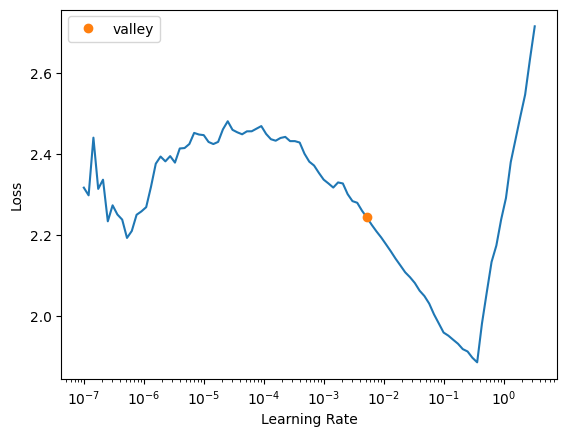

In [70]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.lr_find()